In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df = pd.read_csv('SolarPrediction.csv')
df

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00


In [3]:
import data_prep

target_col = 'Radiation'  # Column to predict


X_train, X_val, X_test, y_train, y_val, y_test, scalers, feature_cols, transform_info = data_prep.prepare_weather_data(
        df,     
        target_col='Radiation',  
        window_size=24,
        feature_selection_mode='basic',  # Start with basic features
        standardize_features=False,  # Try StandardScaler
        use_solar_elevation=True,  # Try the solar elevation feature
        use_piecewise_transform=False,  # Start without piecewise transform
        log_transform=True, #figured out this one is super important
        #min_target_threshold=1.2
)

Adding solar elevation proxy feature
SolarElevation created for 32686 rows, 100.0% of data
Added 'Radiation_is_low' feature (threshold: 1.2000)
Added SolarElevation to features
Log-transformed Radiation -> Radiation_log
Using MinMaxScaler for feature scaling
X_train shape: (19596, 24, 17)
y_train shape: (19596, 1)
X_val shape: (6533, 24, 17)
y_val shape: (6533, 1)
X_test shape: (6533, 24, 17)
y_test shape: (6533, 1)
Features used: ['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeMinutesSin', 'TimeMinutesCos', 'Radiation_is_low', 'SolarElevation', 'SunriseMinutes', 'SunsetMinutes', 'DaylightMinutes', 'TimeSinceSunrise', 'TimeUntilSunset', 'DaylightPosition', 'HourOfDay']


In [4]:
import gru 

model = gru.WeatherGRU(
    input_dim=X_train.shape[2],
    hidden_dim=64,
    num_layers=2,
    output_dim=1,
    dropout_prob=0.3
)


In [5]:
model.fit(         
        X_train, y_train, X_val, y_val, 
        epochs=100, 
        batch_size=32, 
        learning_rate=0.001, )

Epoch 10/100 | Train Loss: 0.0035 | Val Loss: 0.0044 | Train MAPE: 105.22% | Val MAPE: 82.17% | Val RMSE: 0.0660 | Val R²: 0.9684 | LR: 0.001000
Epoch 20/100 | Train Loss: 0.0031 | Val Loss: 0.0032 | Train MAPE: 103.83% | Val MAPE: 69.48% | Val RMSE: 0.0568 | Val R²: 0.9766 | LR: 0.001000
Epoch 30/100 | Train Loss: 0.0029 | Val Loss: 0.0033 | Train MAPE: 97.98% | Val MAPE: 42.54% | Val RMSE: 0.0572 | Val R²: 0.9763 | LR: 0.001000
Epoch 40/100 | Train Loss: 0.0028 | Val Loss: 0.0032 | Train MAPE: 97.59% | Val MAPE: 28.81% | Val RMSE: 0.0567 | Val R²: 0.9767 | LR: 0.001000
Epoch 50/100 | Train Loss: 0.0027 | Val Loss: 0.0030 | Train MAPE: 95.27% | Val MAPE: 34.17% | Val RMSE: 0.0551 | Val R²: 0.9780 | LR: 0.001000
Epoch 60/100 | Train Loss: 0.0027 | Val Loss: 0.0028 | Train MAPE: 95.37% | Val MAPE: 29.27% | Val RMSE: 0.0531 | Val R²: 0.9796 | LR: 0.000500
Early stopping at epoch 69


WeatherGRU(
  (gru): GRU(17, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

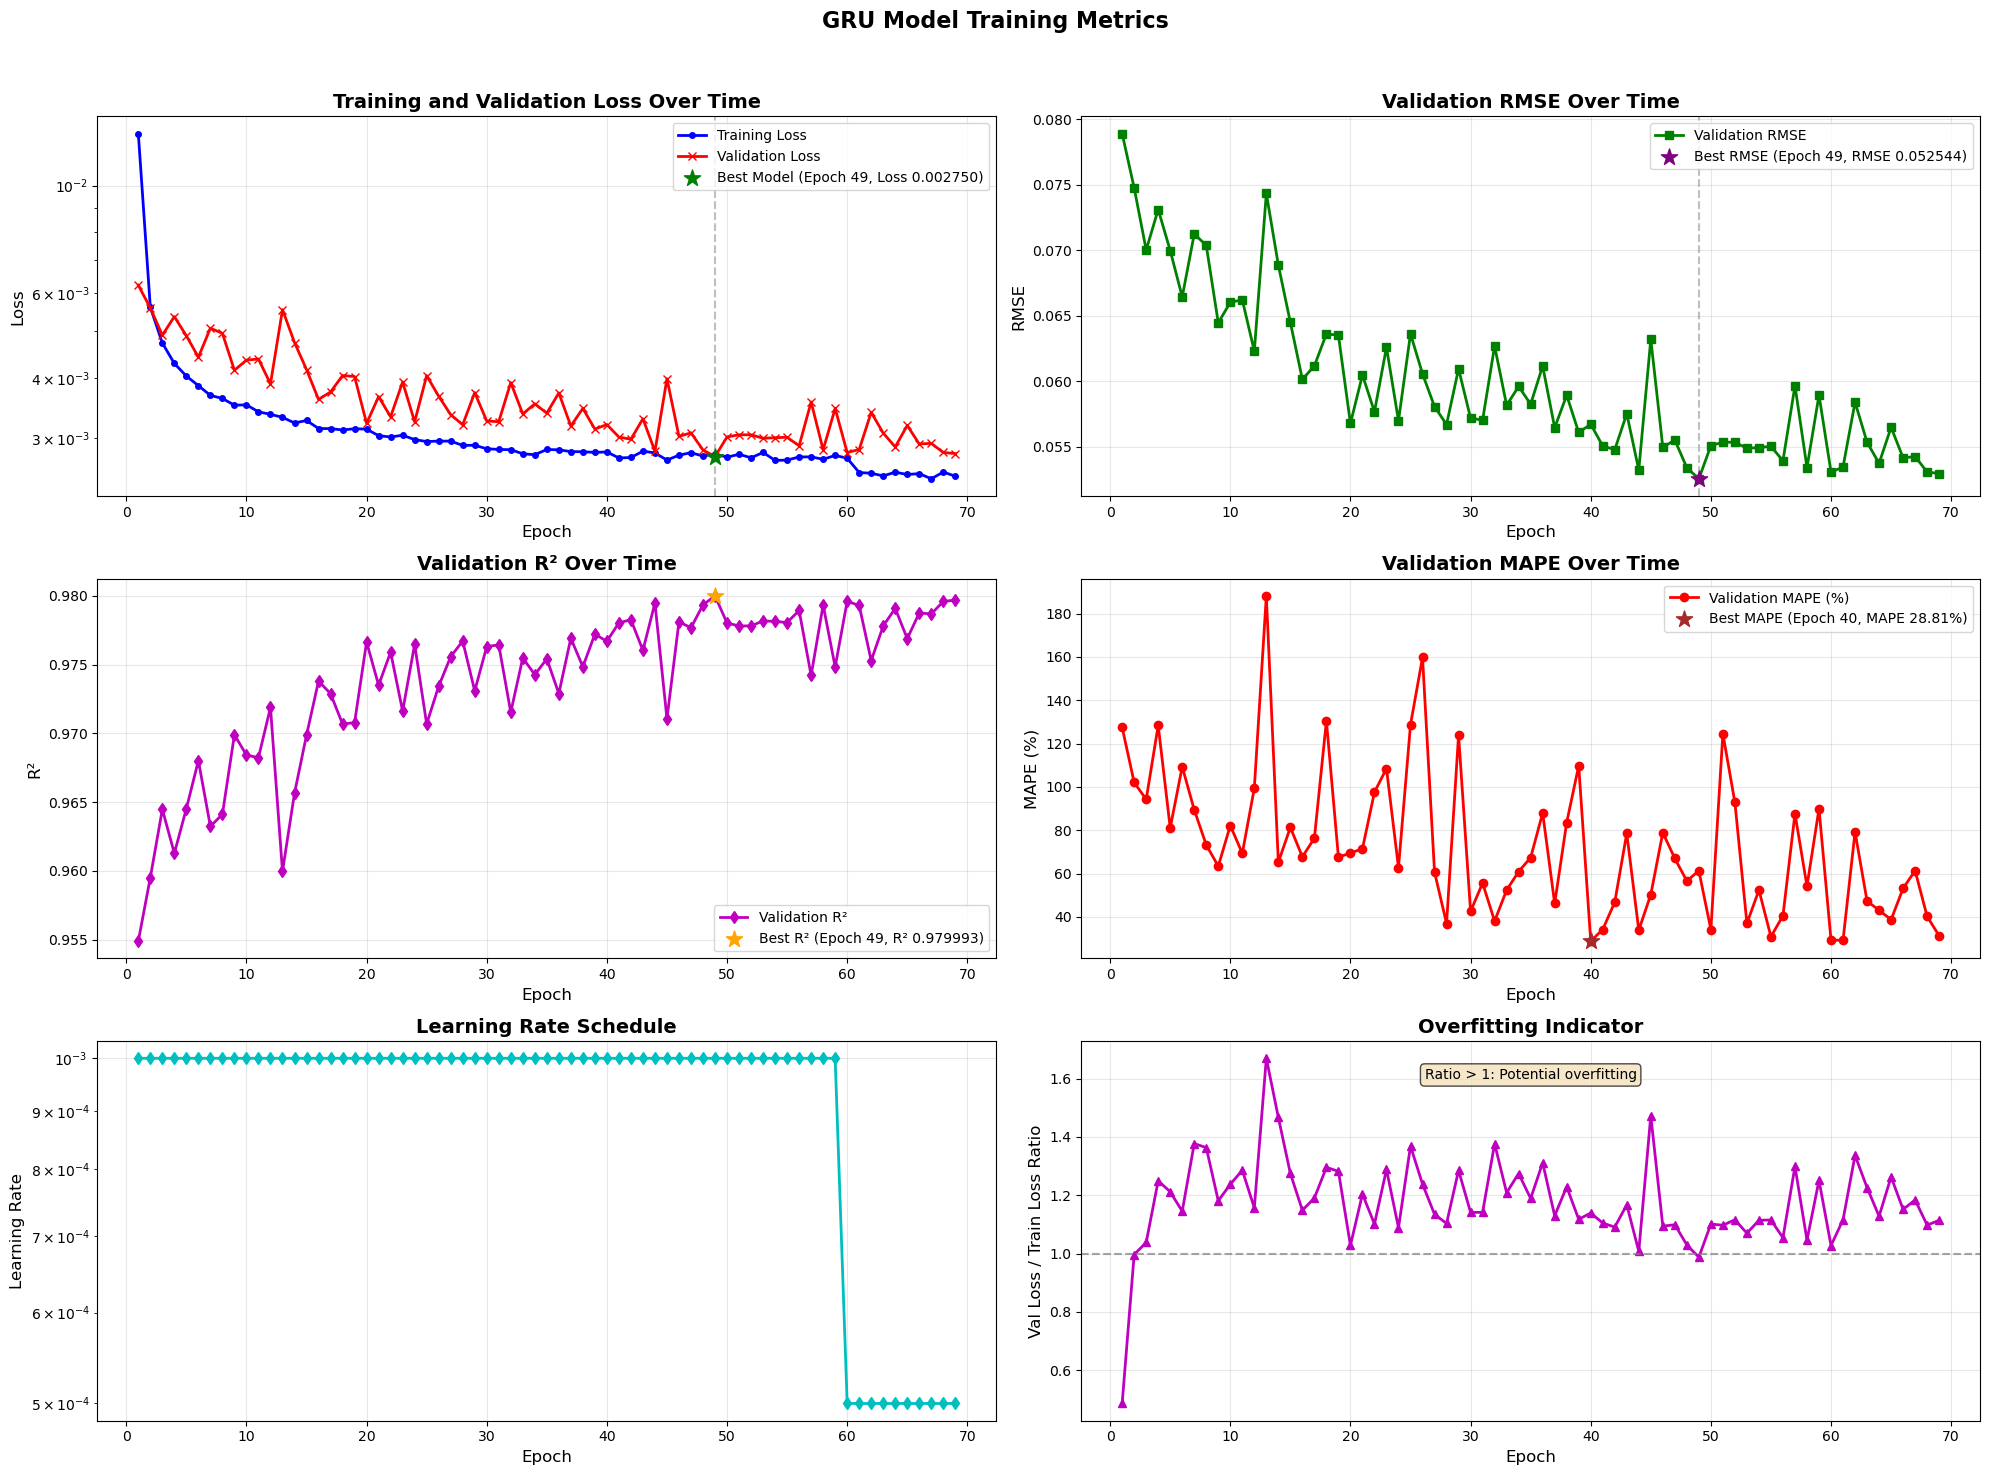

In [12]:
# Visualize training metrics
fig = model.plot_training_history()
plt.show()

In [7]:
metrics, predictions, actuals = model.evaluate(
    X_test, y_test,
    target_scaler=scalers["Radiation_log"],
    transform_info=transform_info
)

Evaluation Metrics:
MSE: 0.1348
RMSE: 0.3671
MAPE: 19.56%
R²: 0.9811


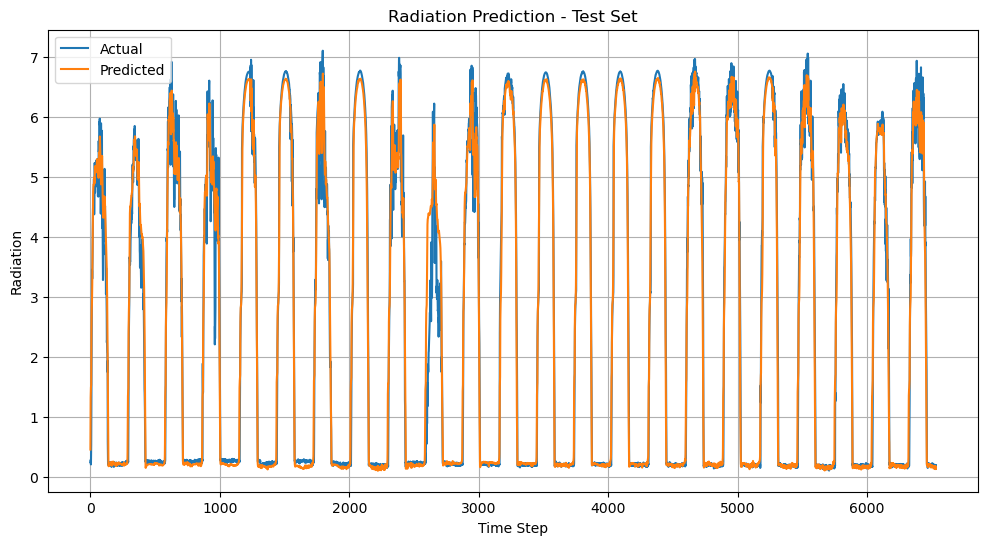

In [13]:
#plot predictions

plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Radiation Prediction - Test Set')
plt.xlabel('Time Step')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.show()

/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:570: RuntimeWarning: overflow encountered in square
  output_errors = _average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1275: RuntimeWarning: overflow encountered in square
  numerator = xp.sum(weight * (y_true - y_pred) ** 2, axis=0)
/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:1277: RuntimeWarning: overflow encountered in square
  weight * (y_true - _average(y_true, axis=0, weights=sample_weight, xp=xp)) ** 2,
/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/sklearn/metrics/_regression.py:940: RuntimeWarning: invalid value encountered in divide
  numerator[valid_score] / denominator[valid_score]


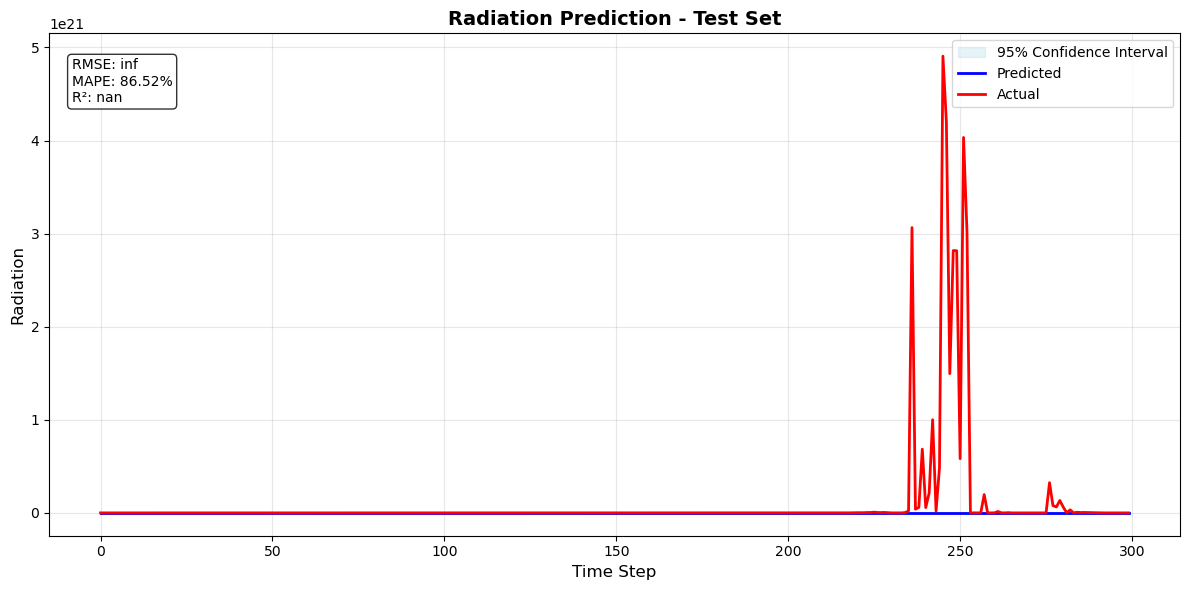

In [14]:
import gru
fig = model.plot_predictions(X_test[2700:3000], actuals[2700:3000], mc_samples=30, 
                                       target_scaler=scalers["Radiation_log"], 
                                       transform_info=transform_info)
plt.show()

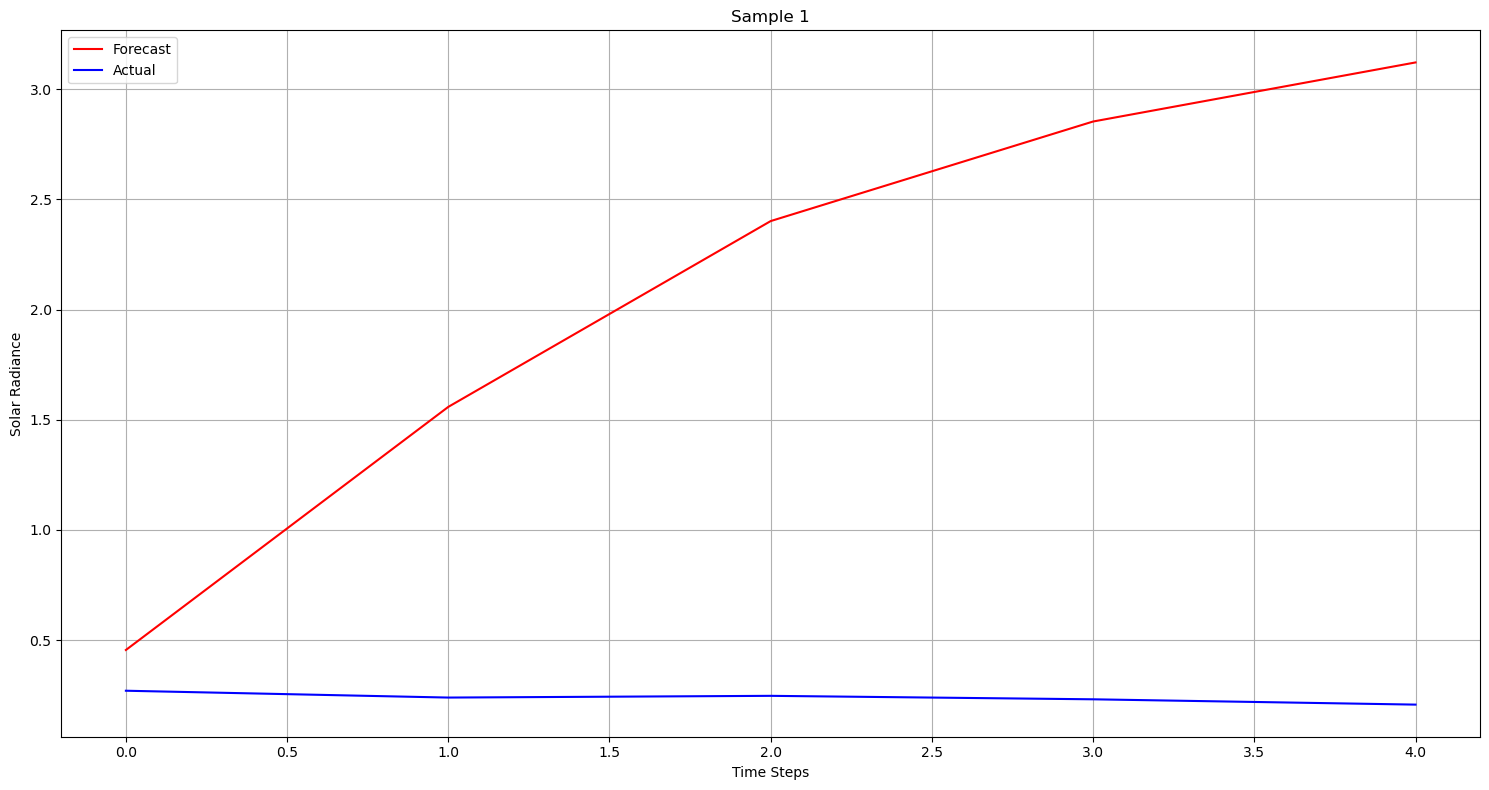

In [ ]:
fig =model.plot_forecast(X_test, y_test, forecast_steps=48, target_scaler=scalers["Radiation_log"],
                     figsize=(15, 8), device="cpu", plot_samples=1, offset=0)
plt.show()

In [11]:
model.save('gru_model.pt')

Model saved to gru_model.pt
